In [3]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap,addcyclic,shiftgrid
from scipy.stats import t
from scipy import stats
import sys
import os

In [4]:
iyr=1850 #initial year
fyr=2014 #final year 
nyr=fyr-iyr+1 # number of year
#Season/month
season='annual'
imon=1
fmon=12
#Region
domain='global'
#Model and variable
model='IPSL-CM6A-LR'
variable='pr'
##Number of members
member='r7i1p1f1'
#member='ensmean'

In [6]:
fh = Dataset('./pr_Amon_IPSL-CM6A-LR_historical_r7i1p1f1_gr_185001-201412.nc', mode = 'r')
#fh = Dataset('./pr_Amon_IPSL-CM6A-LR_historical_emi1p1f1_gr_185001-201412.nc', mode = 'r')
field0= fh.variables['pr'][:] 
units=fh.variables['pr'].units
xlon0 = fh.variables['lon'][:]
##Shifting longitude from 0 to 360 to -180 to 180
##https://matplotlib.org/basemap/api/basemap_api.html
field,xlon = shiftgrid(180., field0, xlon0, start=False)
nlon=len(xlon)
ylat = fh.variables['lat'][:]
nlat=len(ylat)
time=fh.variables['time']
fh.close()

In [7]:
%reset_selective -f field0

In [8]:
field=field[(12*(iyr-1850)):(12*(fyr+1-1850)),:,:]*86400

In [9]:
value=np.zeros((nyr,nlat,nlon))
for i in range(nyr):
    tmp=field[12*i+(imon-1):12*i+(fmon),:,:]
    value[i,:,:]=np.mean(tmp,axis=0)

In [10]:
%reset_selective -f field

In [11]:
#clim=np.zeros((nlat,nlon))
clim=np.ma.mean(value,axis=0)  
#std=np.ma.std(value,axis=0)

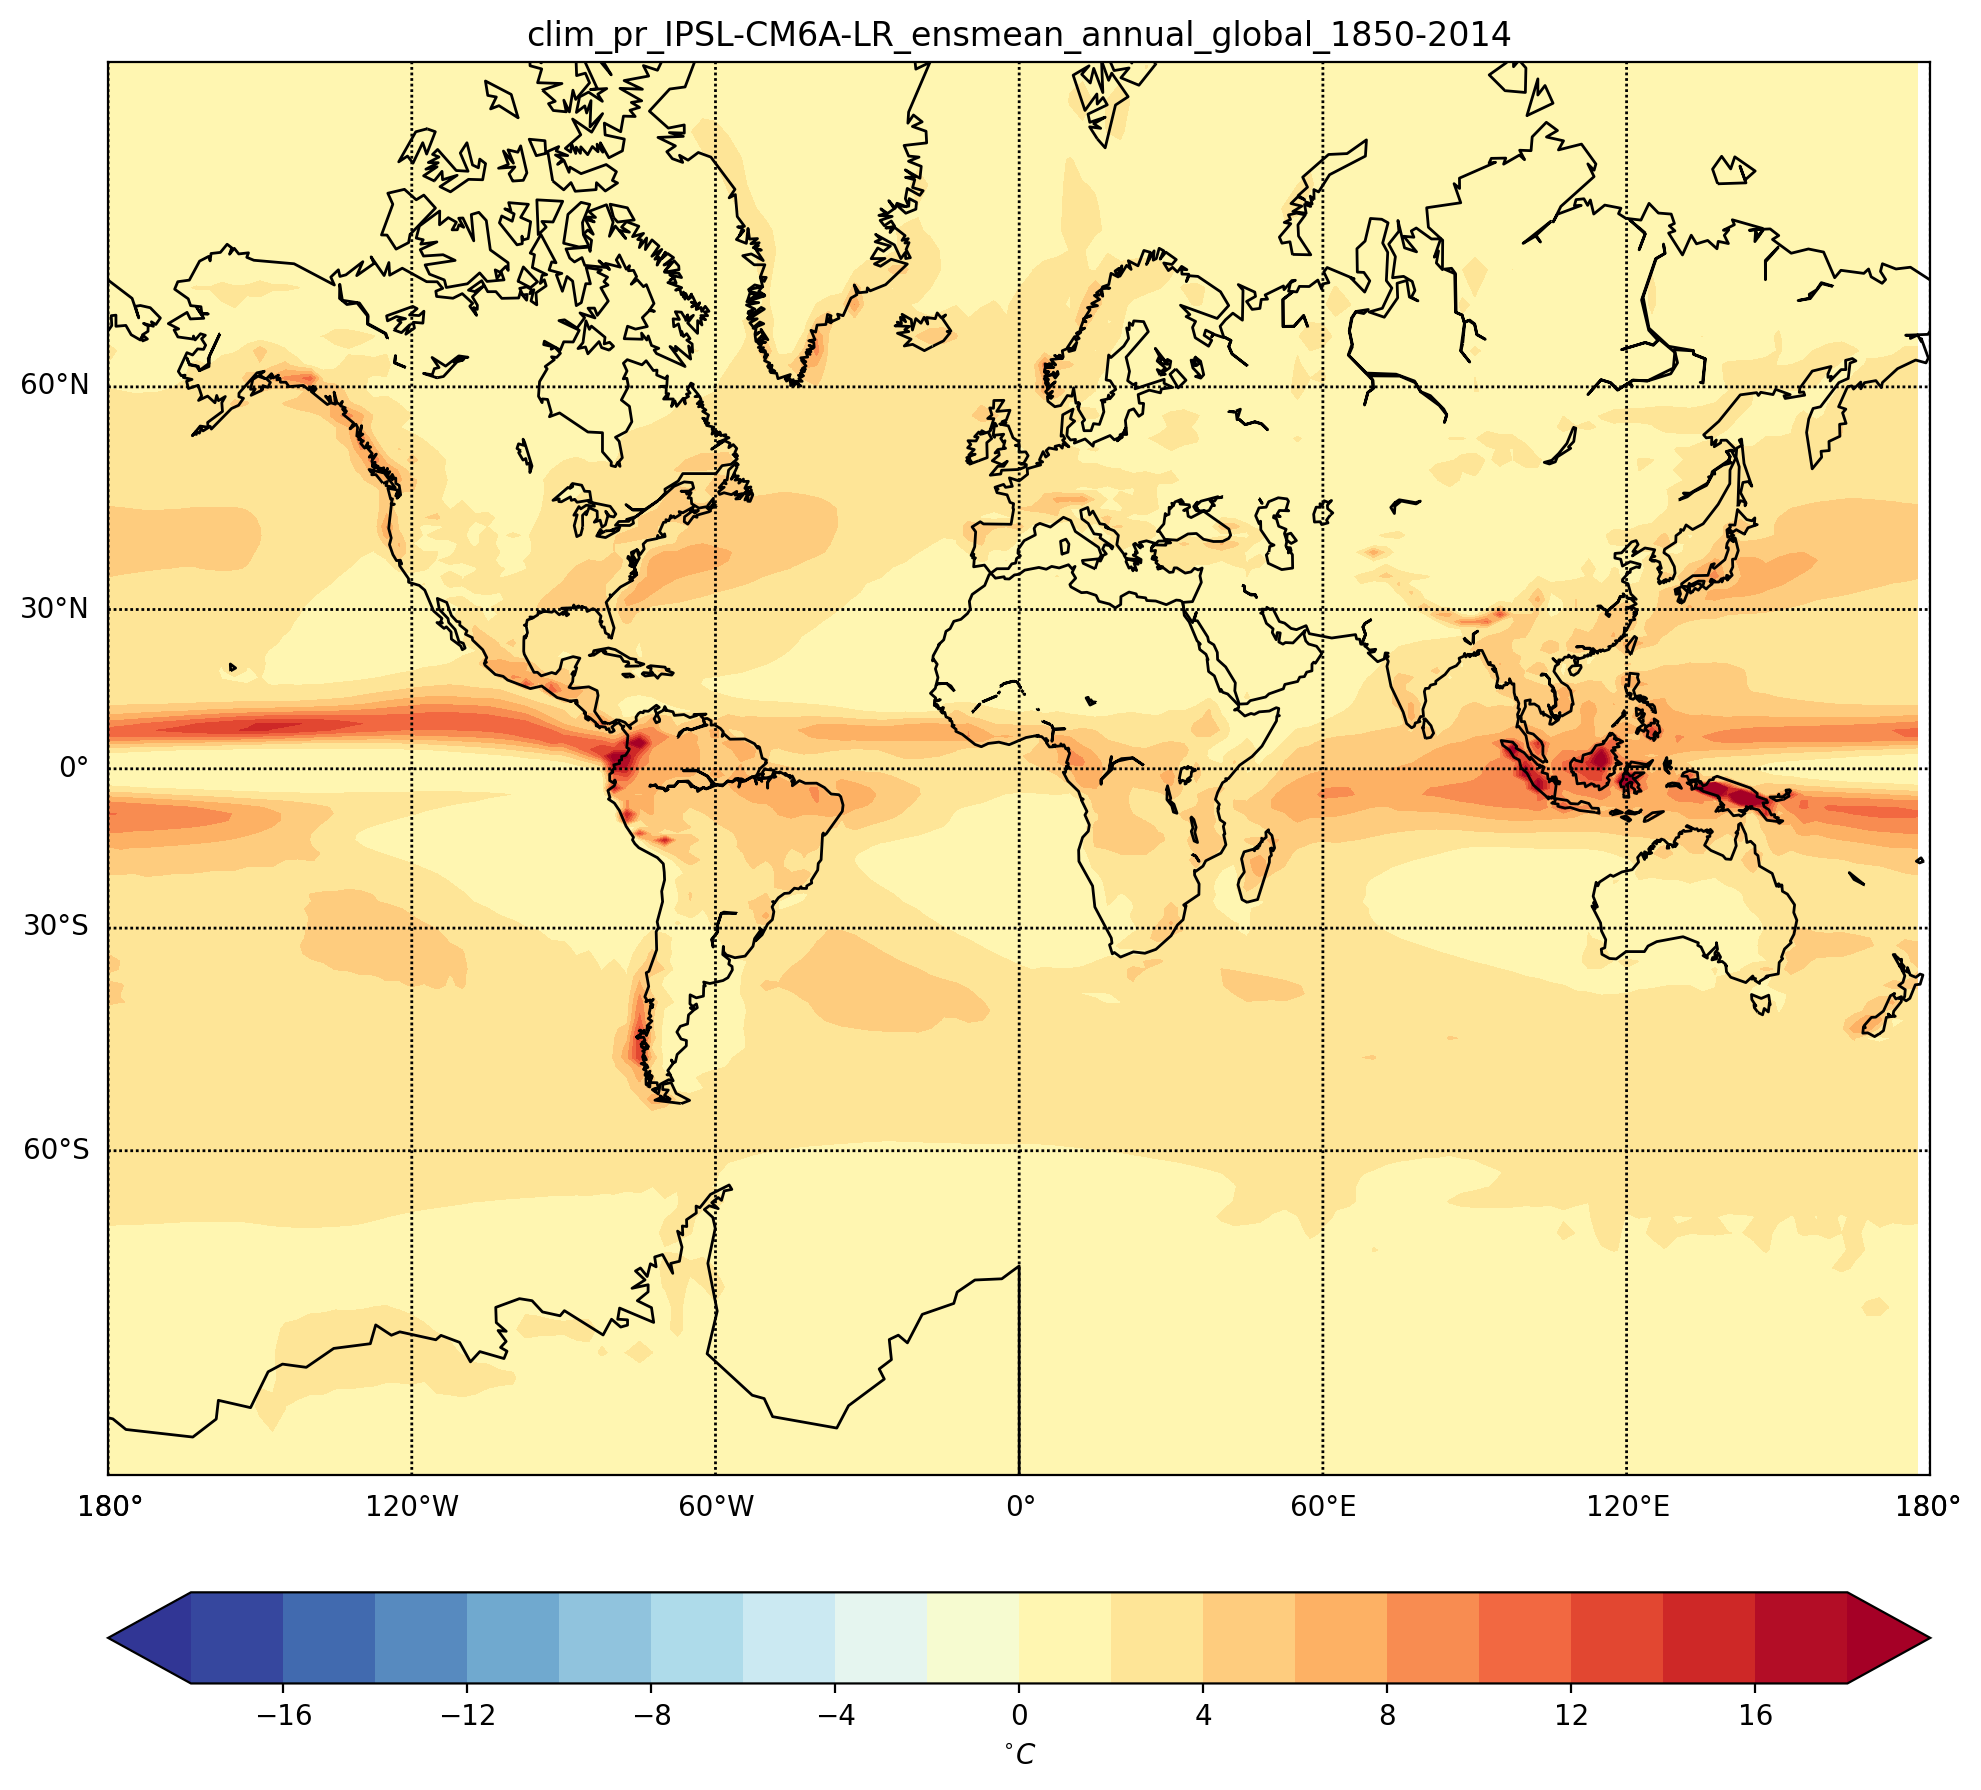

In [12]:
fig=plt.figure(figsize=(10,12))
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
lons, lats = np.meshgrid(xlon,ylat)
clevs=np.arange(-18,20,2)
cmap=plt.cm.RdYlBu_r
CS1 = m.contourf(lons,lats,clim[:,:],clevs,cmap=cmap,latlon=True,extend='both')
cb = fig.colorbar(CS1,orientation="horizontal", pad=0.05)
cb.set_label('$^{\circ}C$', fontsize=10)
plotname='clim_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,domain,iyr,fyr)
plt.title('%s'%(plotname), fontsize=12)
plt.tight_layout()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [12]:
print(xlon)

[-180.  -177.5 -175.  -172.5 -170.  -167.5 -165.  -162.5 -160.  -157.5
 -155.  -152.5 -150.  -147.5 -145.  -142.5 -140.  -137.5 -135.  -132.5
 -130.  -127.5 -125.  -122.5 -120.  -117.5 -115.  -112.5 -110.  -107.5
 -105.  -102.5 -100.   -97.5  -95.   -92.5  -90.   -87.5  -85.   -82.5
  -80.   -77.5  -75.   -72.5  -70.   -67.5  -65.   -62.5  -60.   -57.5
  -55.   -52.5  -50.   -47.5  -45.   -42.5  -40.   -37.5  -35.   -32.5
  -30.   -27.5  -25.   -22.5  -20.   -17.5  -15.   -12.5  -10.    -7.5
   -5.    -2.5    0.     2.5    5.     7.5   10.    12.5   15.    17.5
   20.    22.5   25.    27.5   30.    32.5   35.    37.5   40.    42.5
   45.    47.5   50.    52.5   55.    57.5   60.    62.5   65.    67.5
   70.    72.5   75.    77.5   80.    82.5   85.    87.5   90.    92.5
   95.    97.5  100.   102.5  105.   107.5  110.   112.5  115.   117.5
  120.   122.5  125.   127.5  130.   132.5  135.   137.5  140.   142.5
  145.   147.5  150.   152.5  155.   157.5  160.   162.5  165.   167.5
  170.

In [13]:
anom=np.zeros((nyr,nlat,nlon))
#anom=ma.masked_array(anom1,mask=field[0:nyr].mask)
for i in range(nyr):
    anom[i,:,:]=value[i,:,:]-clim

In [14]:
%reset_selective -f clim
%reset_selective -f value

In [15]:
deg=1
#deg=int(sys.argv[2])
anom_notrend=np.zeros((nyr,nlat,nlon))
xyears=np.arange(0,nyr,1)
for j in range(nlat):
    for i in range(nlon):
        if deg==1:
            poly=np.polyfit(xyears,anom[:,j,i],deg=1)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears+poly[1])
        elif deg==2:
            poly=np.polyfit(xyears,anom[:,j,i],deg=2)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**2+poly[1]*xyears+poly[2])
        elif deg==3:
            poly=np.polyfit(xyears,anom[:,j,i],deg=3)
            anom_notrend[:,j,i]=anom[:,j,i]-(poly[0]*xyears**3+poly[1]*xyears**2+poly[2]*xyears+poly[3])

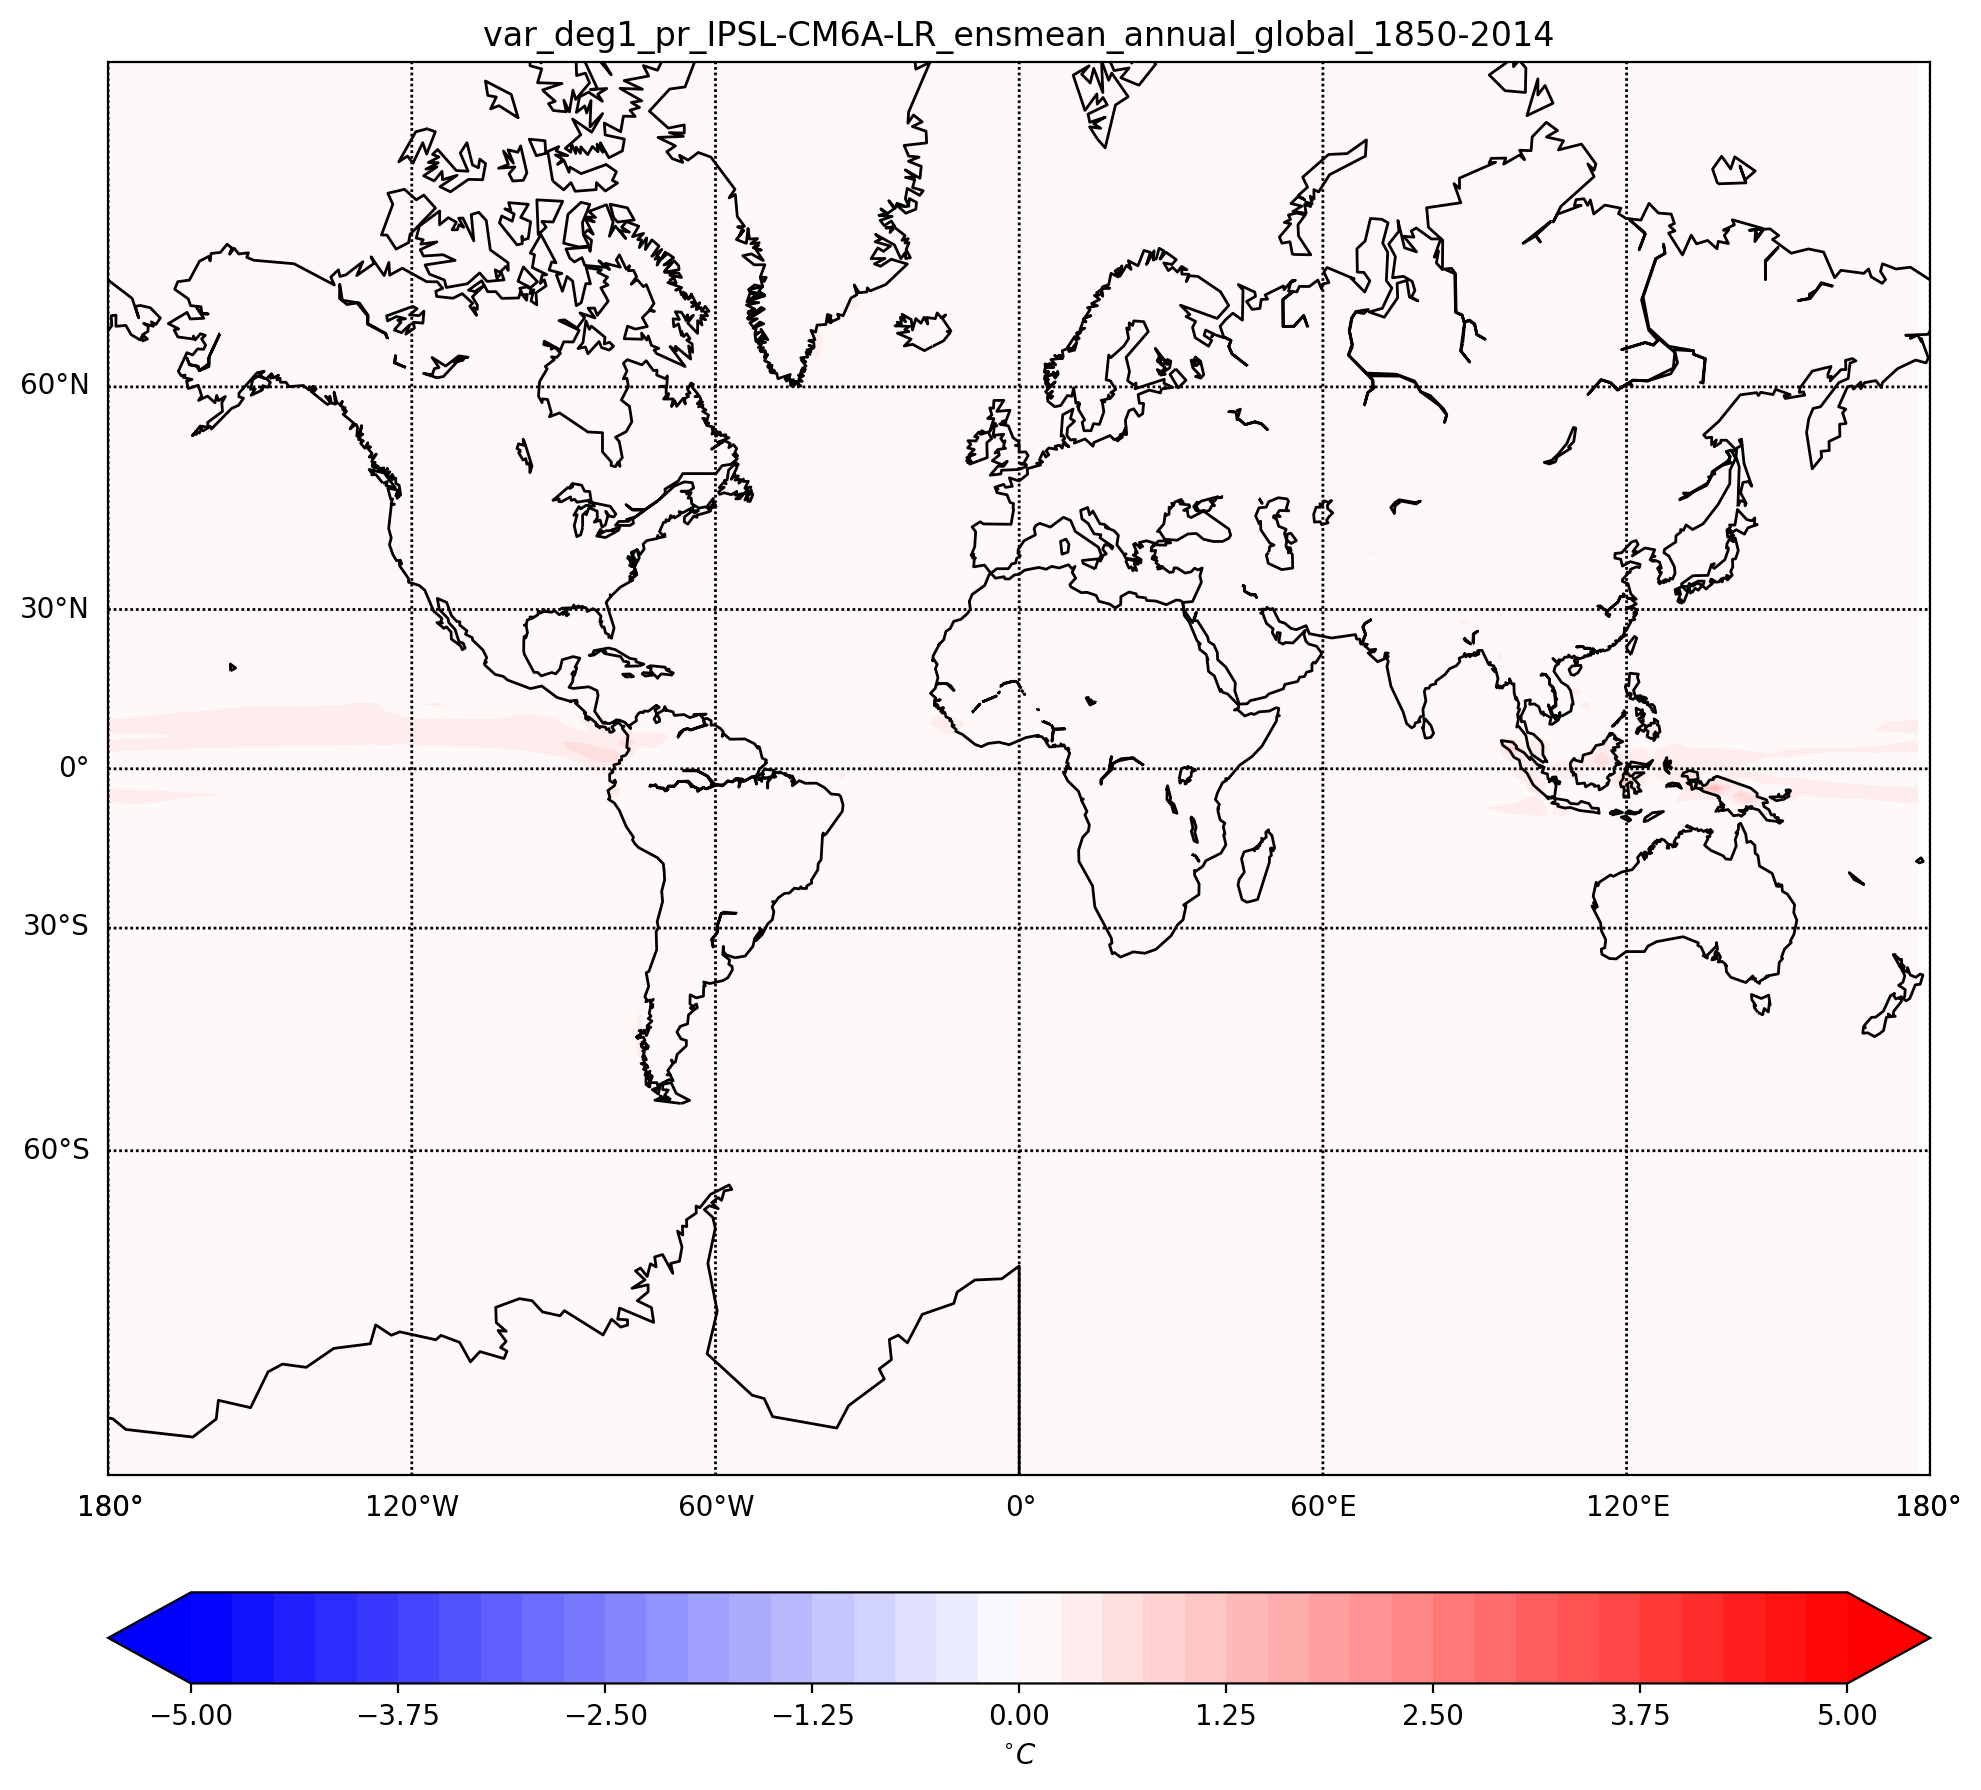

In [16]:
stdnotrend=np.ma.std(anom_notrend,axis=0)
###
##Plotting standard deviation of anomalies
###
fig=plt.figure(figsize=(10,12))

m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
lons, lats = np.meshgrid(xlon,ylat)
clevs=np.arange(-5,5.25,0.25)
cmap=plt.cm.bwr
CS1 = m.contourf(lons,lats,stdnotrend[:,:],clevs,cmap=cmap,latlon=True,extend='both')
cb = fig.colorbar(CS1,orientation="horizontal", pad=0.05)
cb.set_label('$^{\circ}C$', fontsize=10)
plotname='var_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,season,domain,iyr,fyr)
plt.title('%s'%(plotname), fontsize=12)
plt.tight_layout()
##plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [17]:
%reset_selective -f anom_notrend
%reset_selective -f stdnotrend                       

In [18]:
trend=np.empty((nlat,nlon))
#intercept=np.empty((nlat,nlon))
#pvalue=np.empty((nlat,nlon))
#rvalue=np.empty((nlat,nlon))
#stderr=np.empty((nlat,nlon))
xd=np.array(range((nyr)))

In [19]:
for j in range(nlat):
    for i in range(nlon):
        yd=anom[:,j,i]
        par = stats.linregress(xd, yd)
#        stderr[j,i]=par[4]
#        pvalue[j,i]=par[3]
#        rvalue[j,i]=par[2]
#        intercept[j,i]=par[1]
        trend[j,i]=par[0]

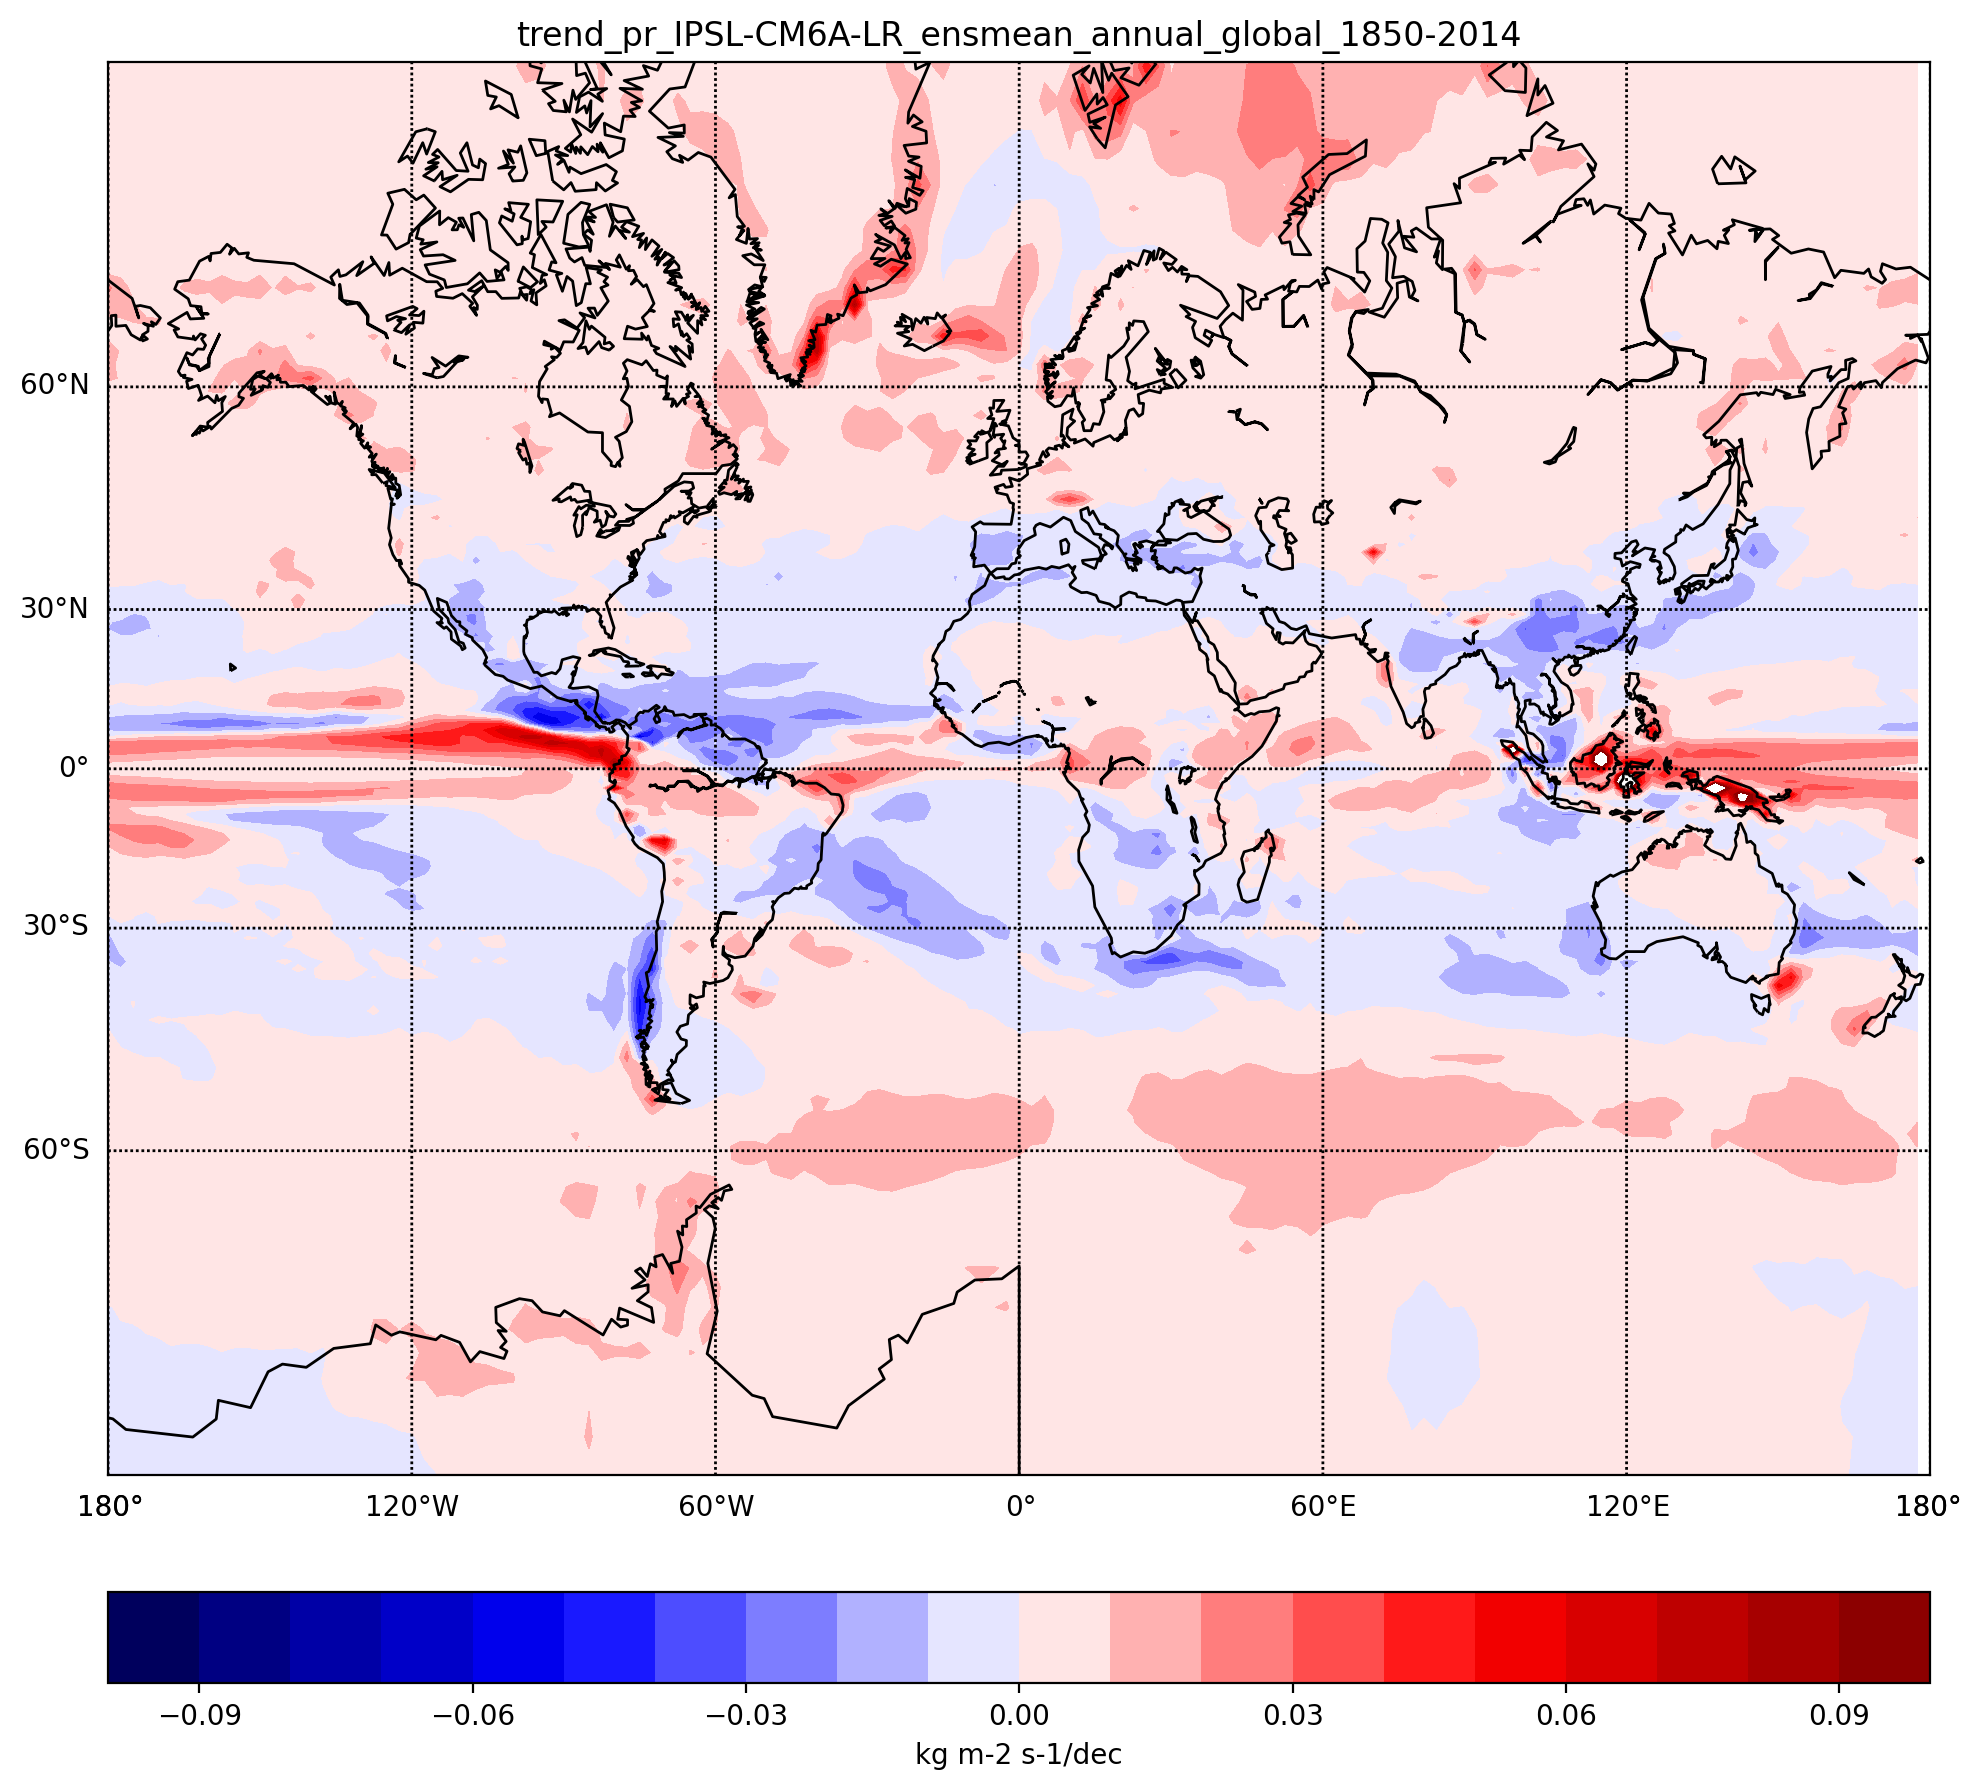

In [20]:
fig=plt.figure(figsize=(10,12))

m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

m.drawcoastlines()
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])
lons, lats = np.meshgrid(xlon,ylat)

clevs=np.arange(-0.1,0.11,0.01)
CS1=m.contourf(lons,lats,trend*10,clevs,cmap=plt.cm.seismic,latlon=True)
#levels=[0,0.1,1.0]
#cs = m.contourf(lons,lats,pvalue,levels=levels,hatches=["+", ""], alpha=0.,latlon=True)
cb = fig.colorbar(CS1,orientation="horizontal",pad=0.05)
cb.set_label('%s/dec'%(units), fontsize=10)
plotname='trend_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,domain,iyr,fyr)
plt.title('%s'%(plotname), fontsize=12)
plt.tight_layout()
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [21]:
print(ylat)

[-90.        -88.73239   -87.46479   -86.19718   -84.92958   -83.66197
 -82.39436   -81.12676   -79.85915   -78.59155   -77.323944  -76.056335
 -74.788734  -73.521126  -72.253525  -70.985916  -69.71831   -68.45071
 -67.1831    -65.91549   -64.64789   -63.380283  -62.112675  -60.84507
 -59.577465  -58.30986   -57.042255  -55.774647  -54.507042  -53.239437
 -51.971832  -50.704224  -49.43662   -48.169014  -46.90141   -45.633804
 -44.366196  -43.09859   -41.830986  -40.56338   -39.295776  -38.028168
 -36.760563  -35.492958  -34.225353  -32.957745  -31.690142  -30.422535
 -29.15493   -27.887323  -26.619719  -25.352112  -24.084507  -22.816902
 -21.549295  -20.28169   -19.014084  -17.746479  -16.478872  -15.211267
 -13.943662  -12.676056  -11.408451  -10.140845   -8.8732395  -7.6056337
  -6.338028   -5.0704226  -3.8028169  -2.5352113  -1.2676057   0.
   1.2676057   2.5352113   3.8028169   5.0704226   6.338028    7.6056337
   8.8732395  10.140845   11.408451   12.676056   13.943662   15.211267

In [21]:
domain='global'

wgts = np.cos(np.deg2rad(ylat))

ts_anoms=np.ma.average(np.ma.average(anom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
#ts_anoms_notrend=np.ma.average(np.ma.average(anom_notrend,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)

#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par = stats.linregress(xd,ts_anoms)
trend=par[0]
intercept=par[1]
#rvalue=par[2]
#pvalue=par[3]
#stderr=par[4]

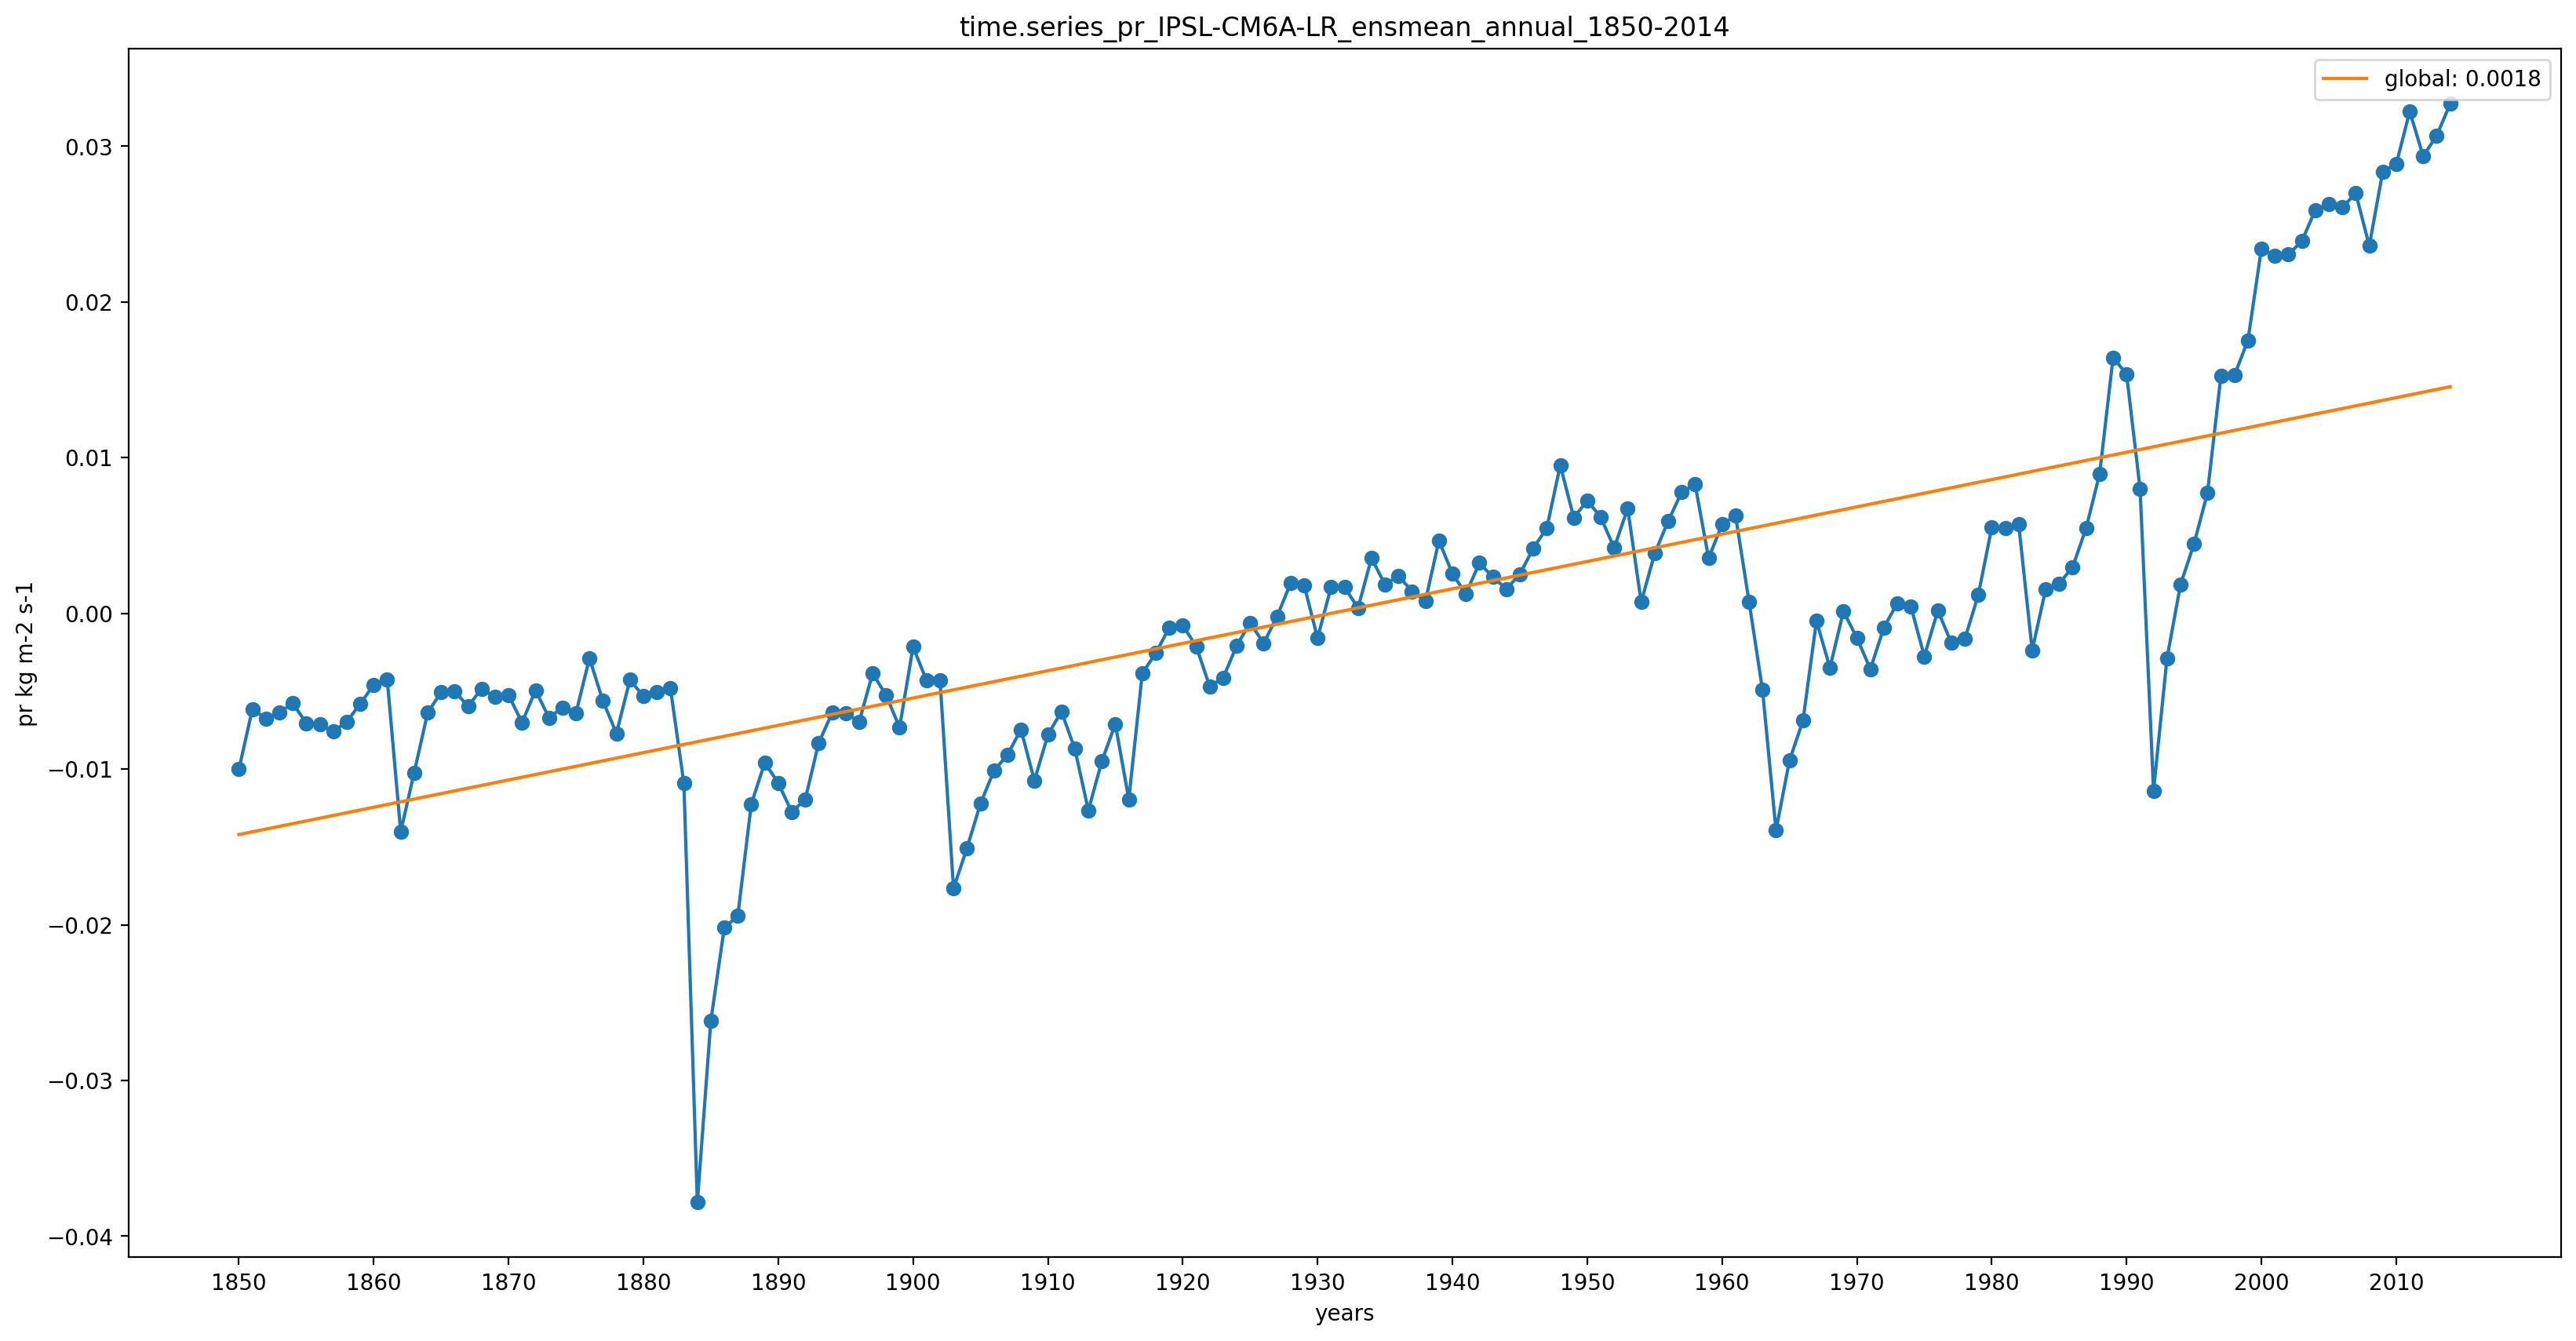

In [22]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s %s'%(variable,units))
plt.xlabel('years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o')
#plt.plot(xdplot,trend*xdplot+intercept,label='t: %1.2f +- err:%1.2f'%(10*trend,10*stderr))
plt.plot(xdplot,trend*xdplot+intercept,label='global'+': %1.4f'%(10*trend))
plt.legend()
#plotname='time.series_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,domain,iyr,fyr)
plotname='time.series_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,iyr,fyr)
plt.title(plotname,fontsize=12)
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [23]:
domain='EuroMed'
xi=70;xf=89
xlon_dom=xlon[xi:xf]
nlon_dom=len(xlon_dom)
yi=92;yf=110
ylat_dom=ylat[yi:yf]
nlat_dom=len(ylat_dom)

#value_dom=value[:,yi:yf,xi:xf,:]
anom_dom=anom[:,yi:yf,xi:xf]
#anom_notrend_dom=anom_notrend[:,yi:yf,xi:xf]

wgts = np.cos(np.deg2rad(ylat_dom))

ts_anoms_dom=np.ma.average(np.ma.average(anom_dom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
#ts_anoms_notrend_dom=np.ma.average(np.ma.average(anom_notrend_dom,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)
#
#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par_dom = stats.linregress(xd,ts_anoms_dom)
trend_dom=par_dom[0]
intercept_dom=par_dom[1]
#rvalue_dom=par_dom[2]
#pvalue_dom=par_dom[3]
#stderr_dom=par_dom[4]

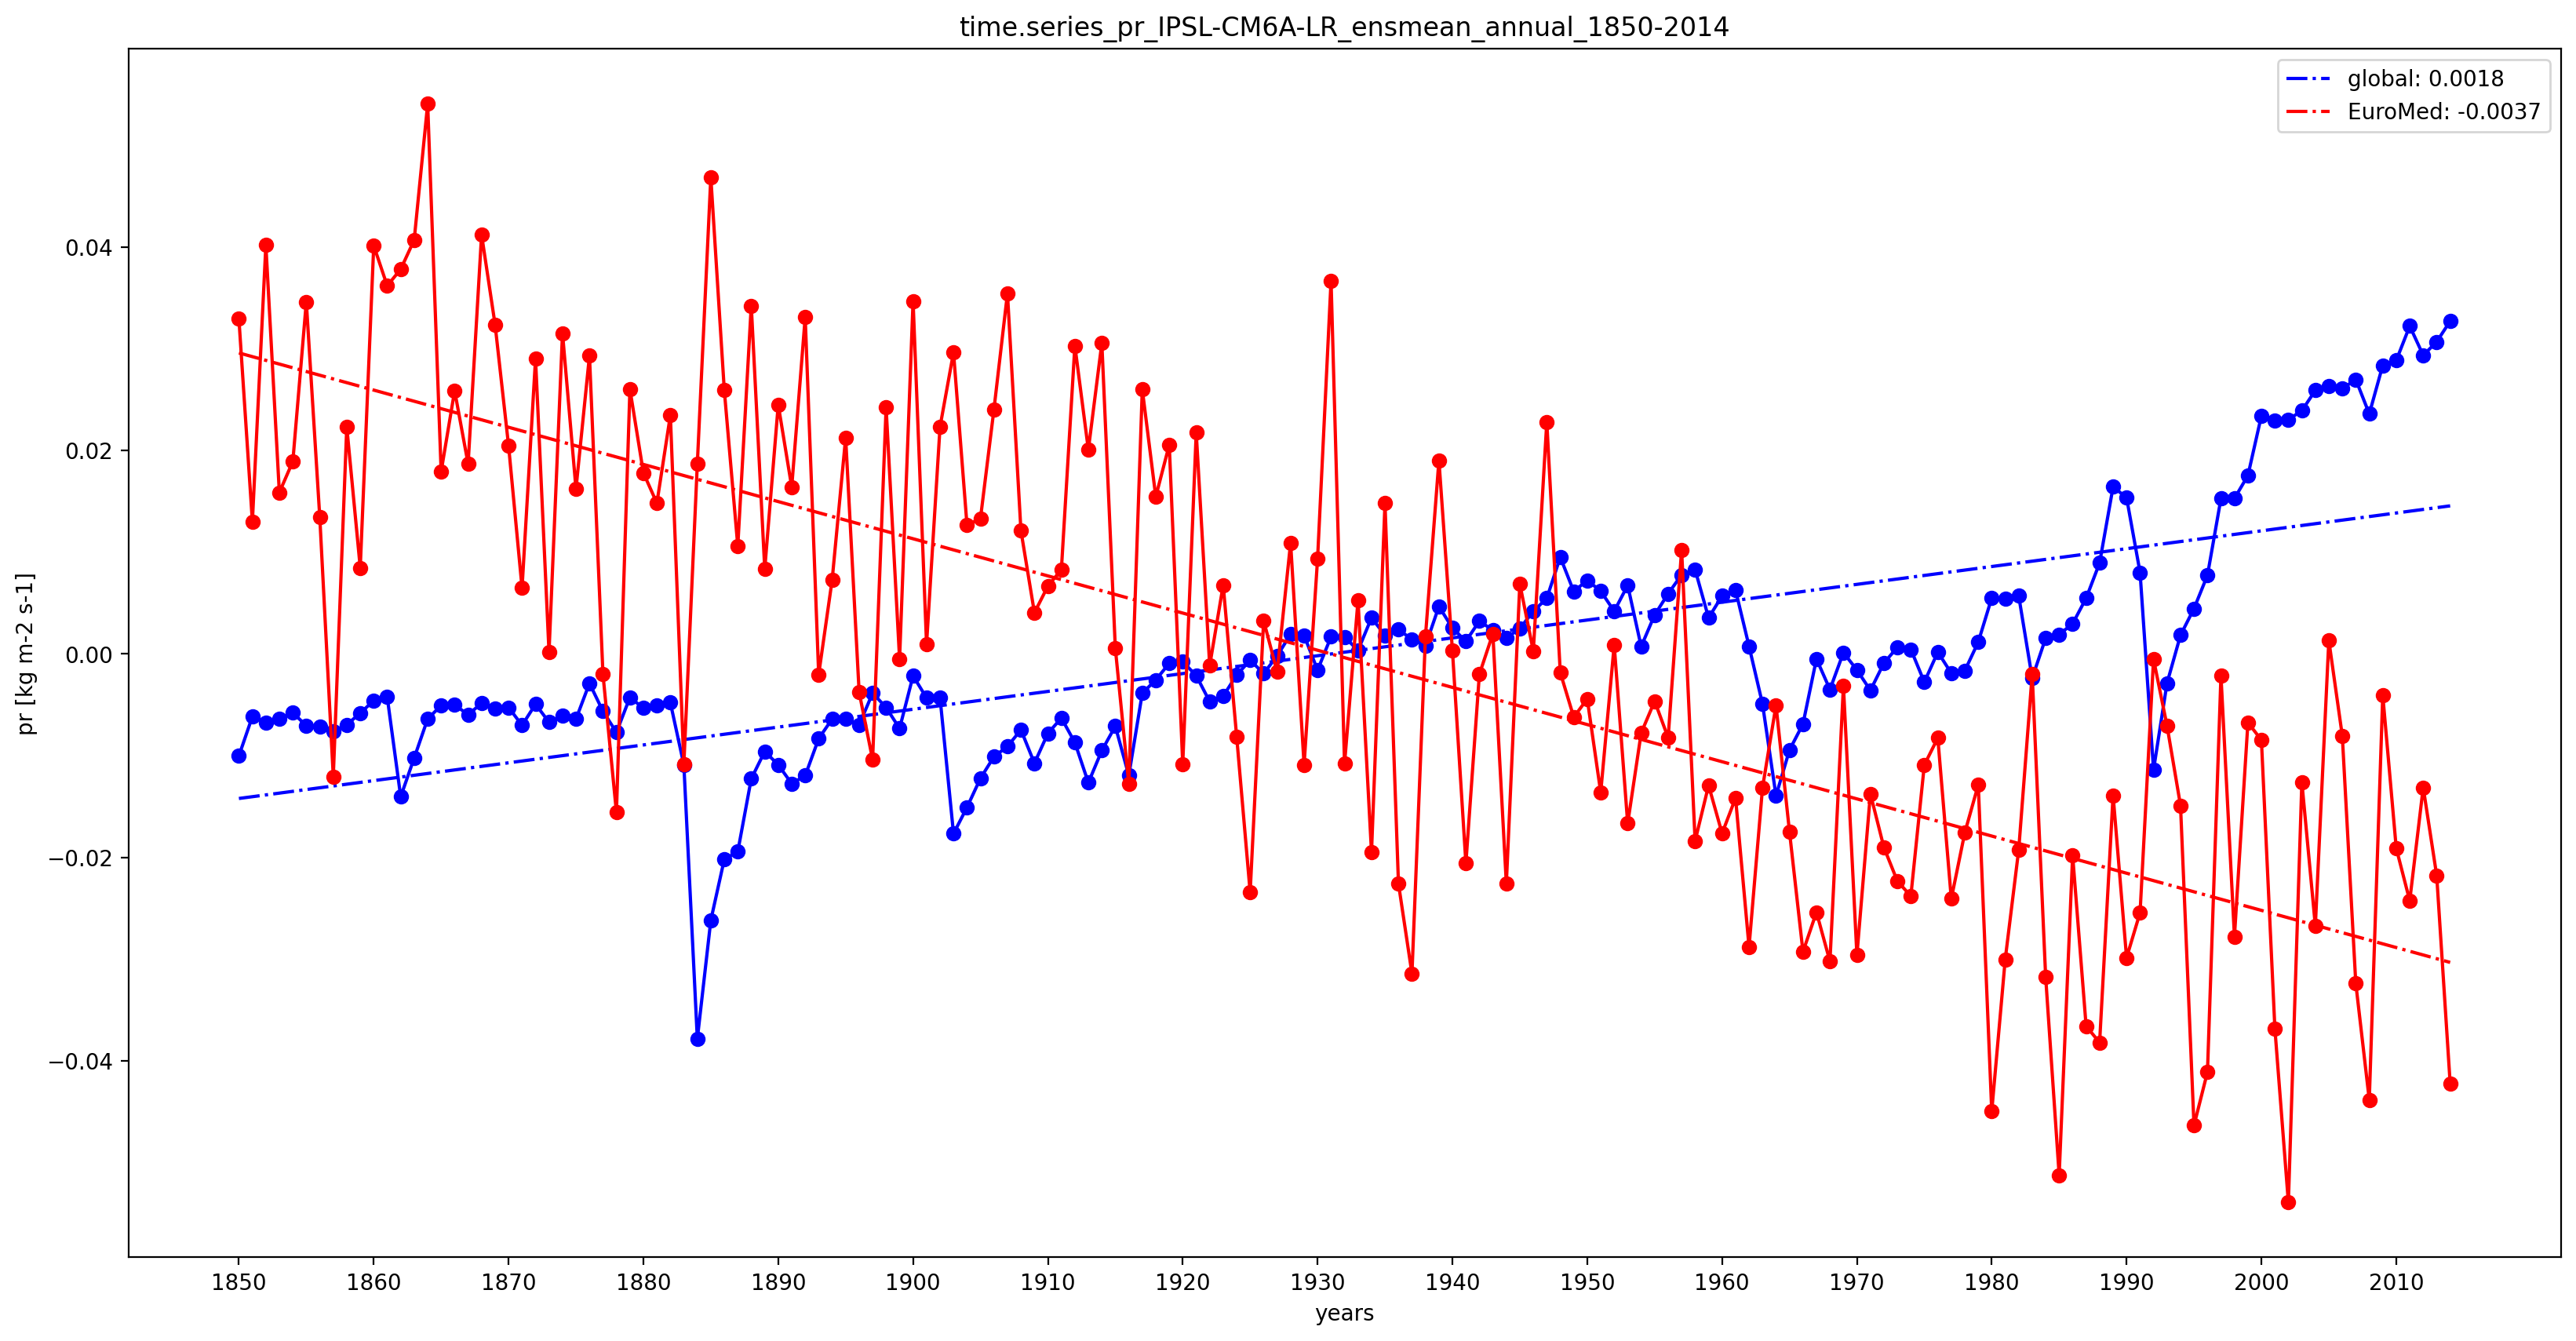

In [24]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s [%s]'%(variable,units))
plt.xlabel('years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.title(plotname,fontsize=12)
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o',color='blue')
#plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.2f +- %1.2f'%(10*trend,10*stderr))
plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.4f'%(10*trend))

plt.plot(xdplot,ts_anoms_dom,linestyle='-',marker='o',color='red')
#plt.plot(xdplot,trend_dom*xdplot+intercept_dom,linestyle='-.',color='red',label=domain+': %1.2f +- %1.2f'%(10*trend_dom,10*stderr_dom))
plt.plot(xdplot,trend_dom*xdplot+intercept_dom,linestyle='-.',color='red',label=domain+': %1.4f'%(10*trend_dom))
plt.legend()

plotname='time.series_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,iyr,fyr)
plt.title(plotname,fontsize=12)
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()

In [25]:
domain='BCN'
ts_anoms_dom=anom[:,103,73]
#ts_anoms_notrend_dom=anom_notrend[:,103,73]

#wgts = np.cos(np.deg2rad(ylat_dom))

#ts_anoms_dom=np.ma.average(np.ma.average(anom_dom,axis=1,weights=wgts),axis=1)  #average in longitude spave_field.shape=(time)
#ts_anoms_notrend_dom=np.ma.average(np.ma.average(anom_notrend_dom,axis=1,weights=wgts),axis=1)

#plotname='timeseries_anoms_%s_%s_%s_%s_%s_%i-%i' %(variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)
#
#plotname='timeseries_anoms_notrend_deg%i_%s_%s_%s_%s_%s_%i-%i' %(deg,variable,model,member,domain,season,iyr,fyr)
#np.savetxt(resultsDir + plotname + '.txt',ts_anoms)


xd=np.array(range(nyr))
par_dom = stats.linregress(xd,ts_anoms_dom)
trend_dom=par_dom[0]
intercept_dom=par_dom[1]
#rvalue_dom=par_dom[2]
#pvalue_dom=par_dom[3]
#stderr_dom=par_dom[4]

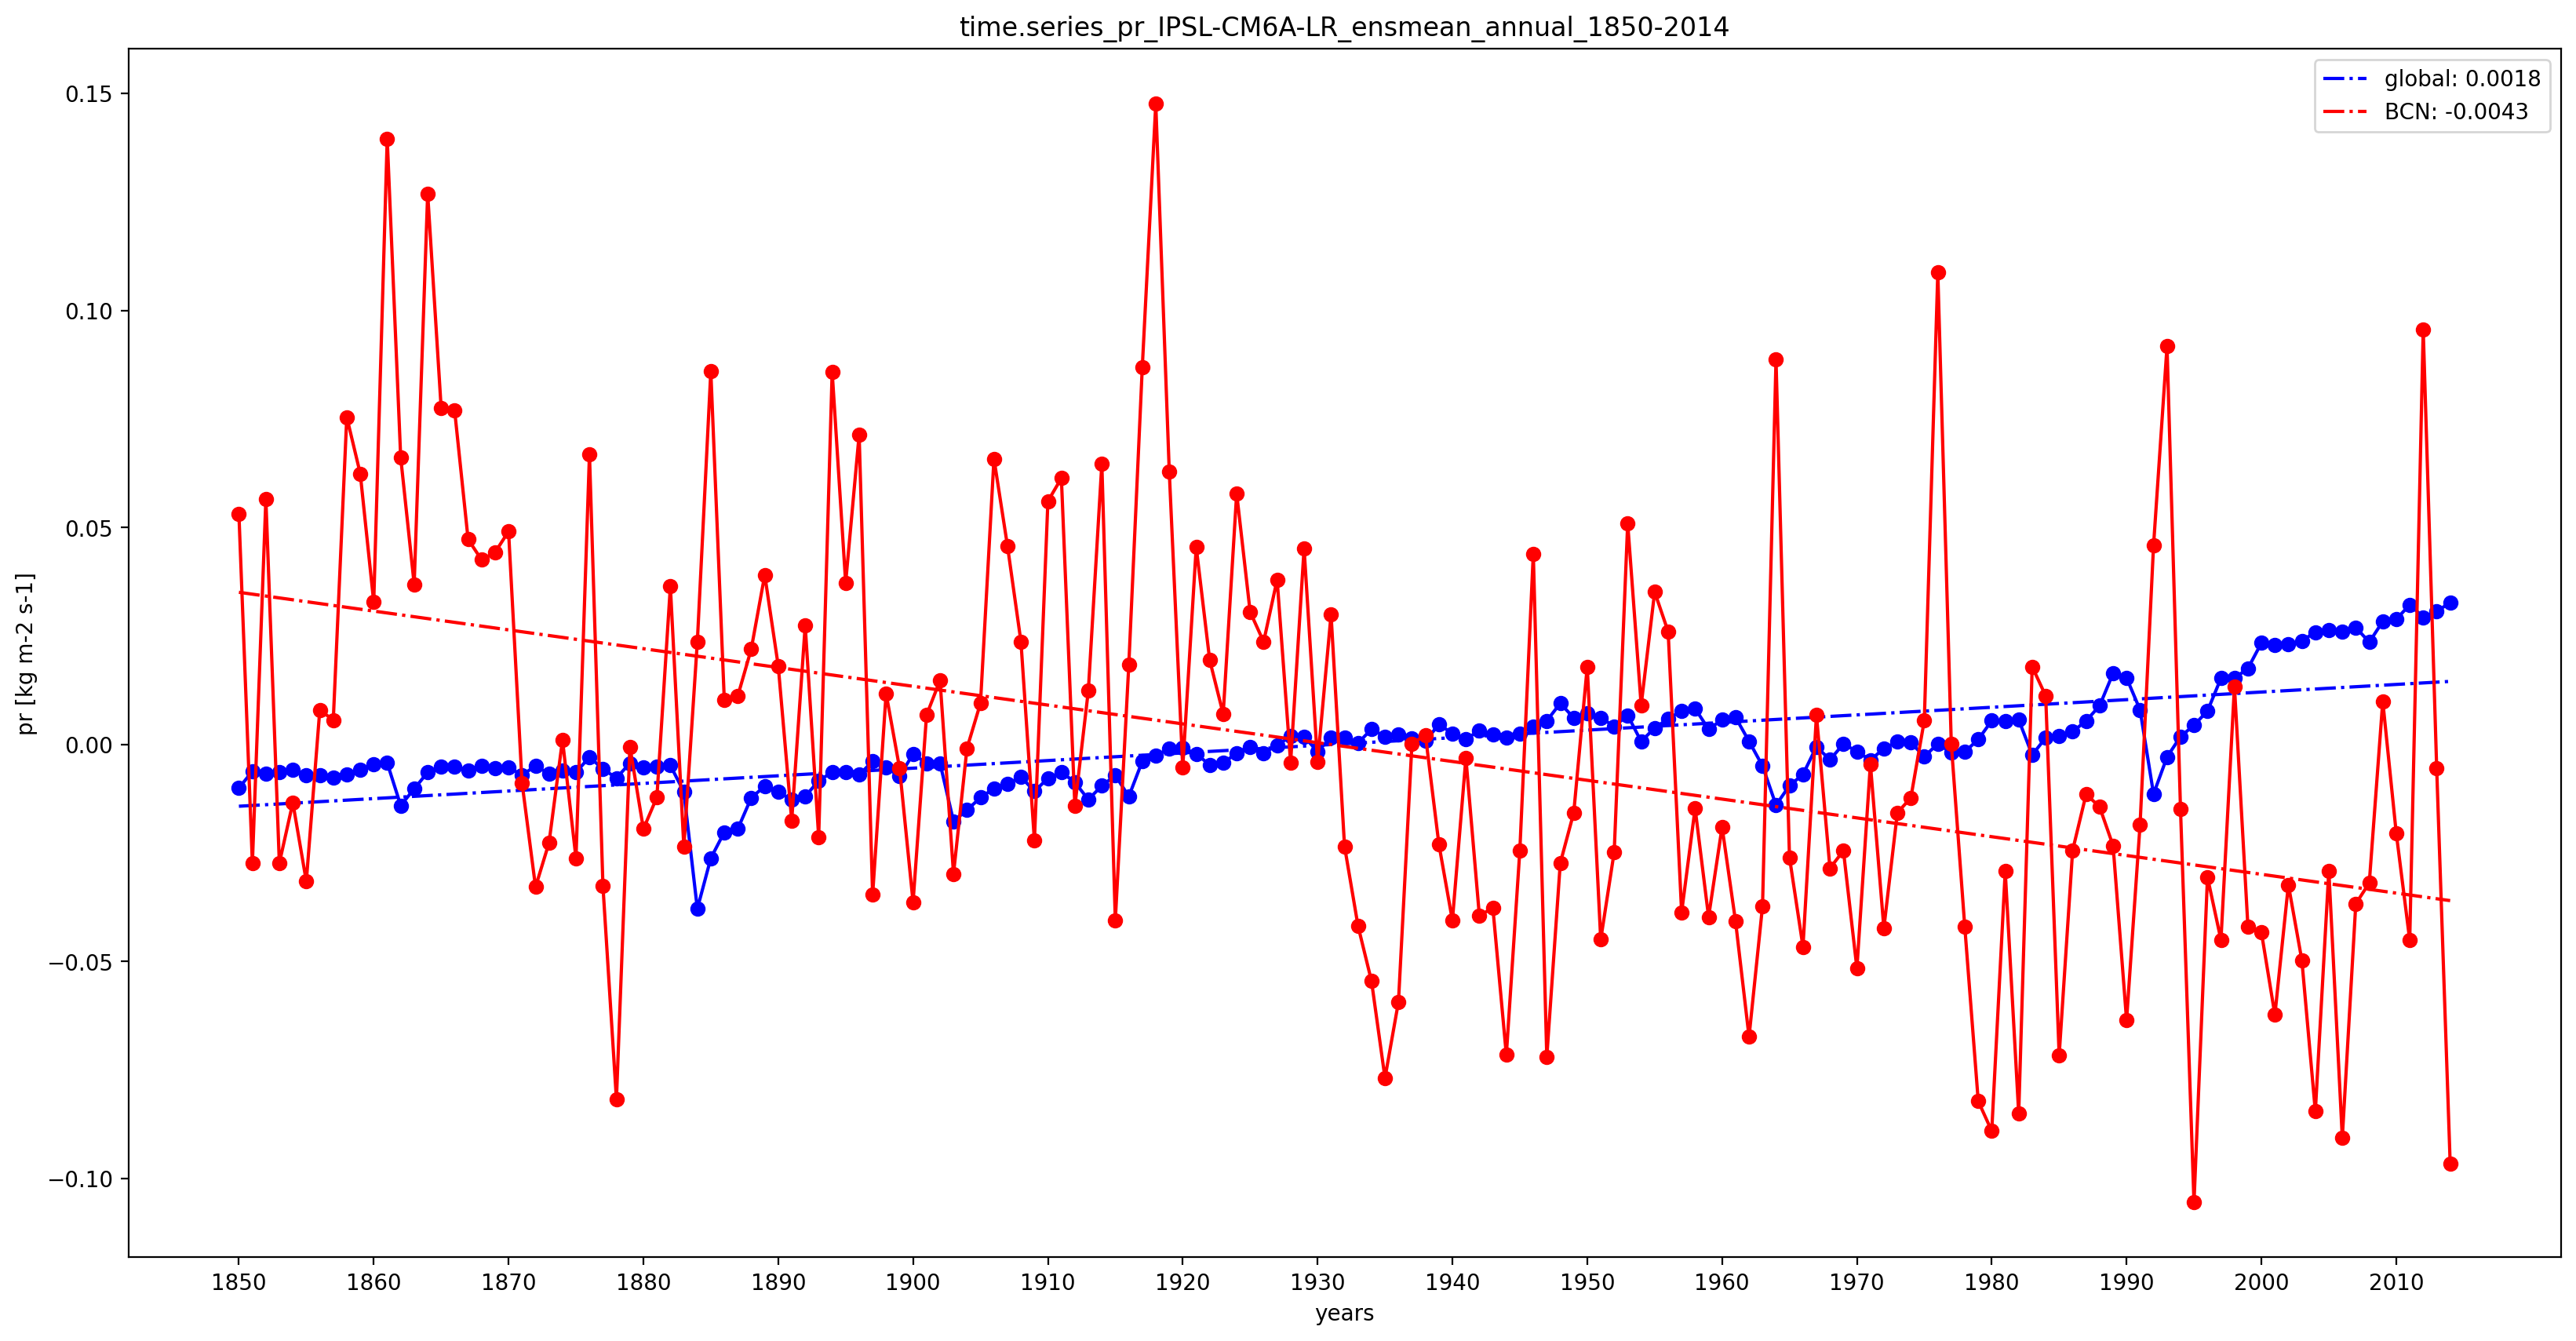

In [26]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
xdplot=xd+1
my_ticks=np.arange(iyr,fyr+1,1)
frequency=10
#plt.ylim(0,100)
plt.ylabel('%s [%s]'%(variable,units))
plt.xlabel('years')
plt.xticks(xdplot[::frequency],my_ticks[::frequency])
plt.title(plotname,fontsize=12)
plt.plot(xdplot,ts_anoms,linestyle='-',marker='o',color='blue')
#plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.2f +- %1.2f'%(10*trend,10*stderr))
plt.plot(xdplot,trend*xdplot+intercept,linestyle='-.',color='blue',label='global'+': %1.4f'%(10*trend))

plt.plot(xdplot,ts_anoms_dom,linestyle='-',marker='o',color='red')
#plt.plot(xdplot,trend_dom*xdplot+intercept_dom,linestyle='-.',color='red',label=domain+': %1.2f +- %1.2f'%(10*trend_dom,10*stderr_dom))
plt.plot(xdplot,trend_dom*xdplot+intercept_dom,linestyle='-.',color='red',label=domain+': %1.4f'%(10*trend_dom))
plt.legend()

plotname='time.series_%s_%s_%s_%s_%i-%i' %(variable,model,member,season,iyr,fyr)
plt.title(plotname,fontsize=12)
#plt.savefig(plotsDir + plotname+ '.png',format='png')
plt.show()